# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

seed = 1234

# Dataset

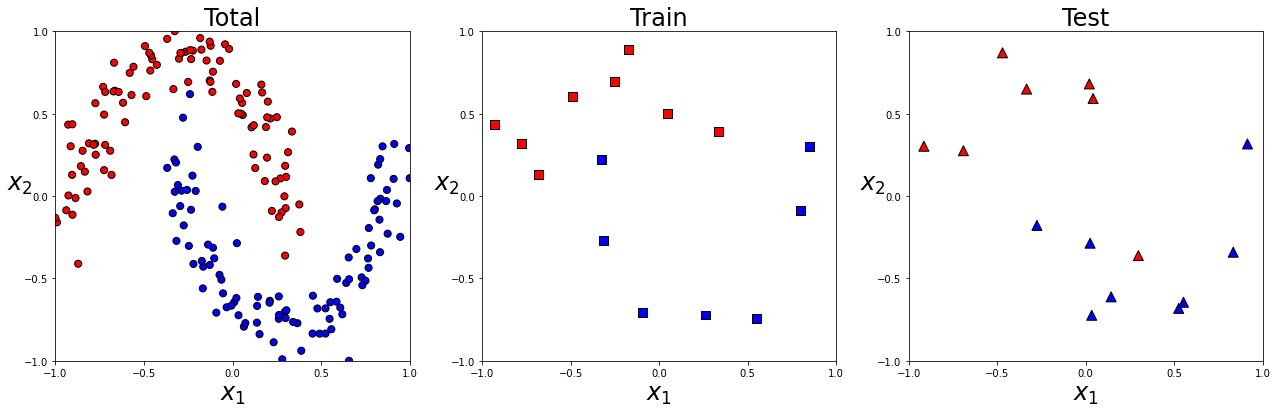

In [2]:
# Sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.datasets import make_moons
np.random.seed(seed)

# Total number of the dataset points
n_samples = 200
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)
y = 2*y-1 # rescale to [-1,1]

# Data rescaling
xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)

train_size = 15 
test_size = 15 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=train_size, 
                                                    test_size=test_size, 
                                                    stratify=y,
                                                    random_state=seed)

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=24)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# QKT SVM

## Setting up the quantum feature map 

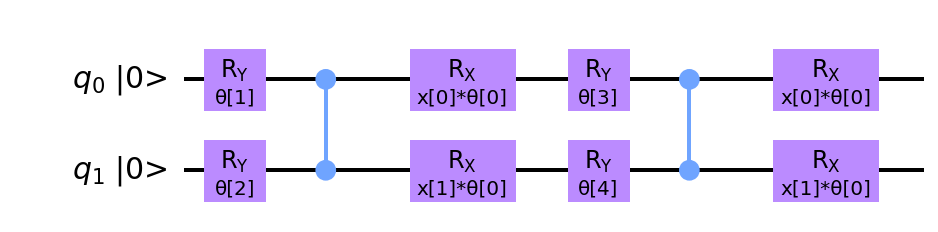

In [3]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['ry', 'cz', 'RX'], entanglement='linear',
    repeat=True,
    scale=True,
)

large_font = {
    "fontsize": 12,
    "subfontsize": 10,  
}
fm.draw(plot_barriers=False, fold=180, output='mpl', scale=2, style=large_font, initial_state=True)

## Examine dependence of the kernel loss function on the data scaling prefactor

In [4]:
#------------------------
# Choose quantum backend
#------------------------
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = seed
backend = QuantumInstance(
    AerSimulator(
        method='statevector',
        max_parallel_threads=8,
    ),
    seed_simulator=seed, seed_transpiler=seed,
)

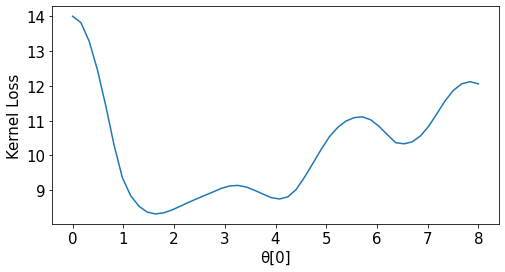

In [5]:
from qksvm.LossFunctions import SVCLoss
from qiskit_machine_learning.kernels import QuantumKernel

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)

## Quantum Kernel Training

SVCLoss optimal value:  4.88902552413335
Optimal parameters: [ 2.72028893 -0.30216811 -1.35025528  5.89906427  7.72610567]


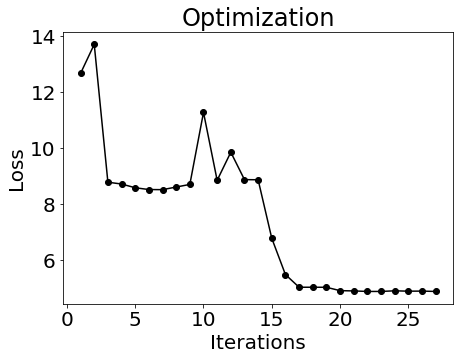


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.93
                  F1:  0.93
             ROC_AUC:  0.93
                 MCC:  0.87


In [6]:
from qksvm.QuantumKernelTraining import QKTKernel
from sklearn.svm import SVC

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    seed=seed, plot=True,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

In [7]:
scores_ = get_scores(qsvc, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.96
                  F1:  0.96
             ROC_AUC:  0.96
                 MCC:  0.93


## Predictions/Decision boundaries plot

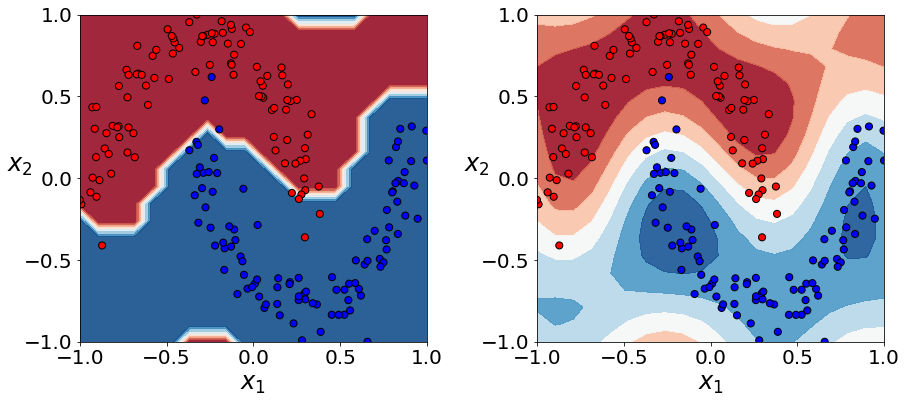

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

## Model cross-validation

SVCLoss optimal value:  4.785946923756665
Optimal parameters: [ 1.7434646   2.40327729 -1.25161352  0.42170709  1.47429057]


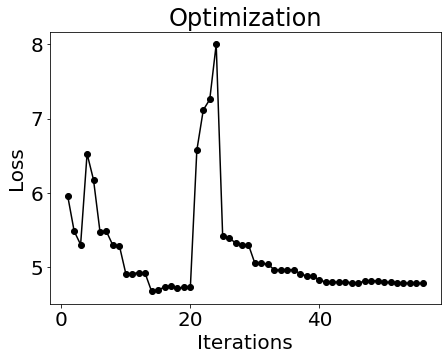

SVCLoss optimal value:  3.366187902941535
Optimal parameters: [ 1.23362006  3.74748792 -2.36028937  0.29349018 -2.52783499]


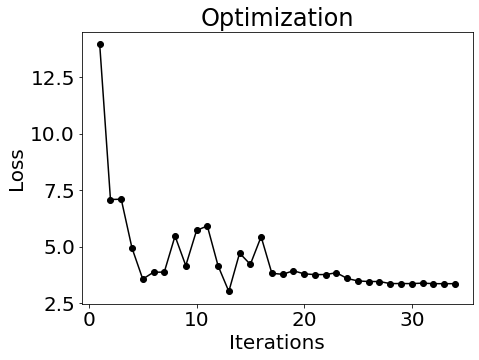

SVCLoss optimal value:  3.3690940357332133
Optimal parameters: [2.27646436 3.16150045 0.84614286 0.16270457 4.11239414]


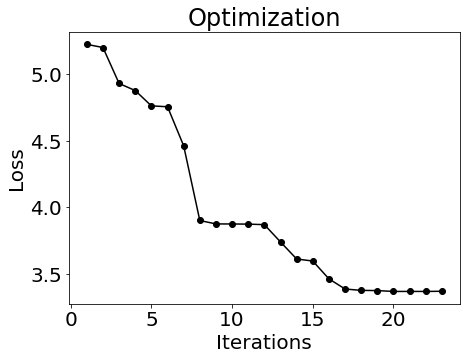

SVCLoss optimal value:  8.225058320440898
Optimal parameters: [1.2629562  4.38167574 0.83757424 0.06999536 4.6224086 ]


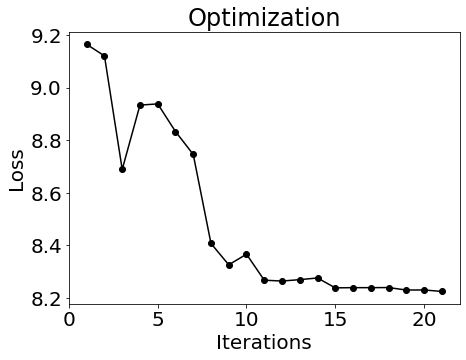

SVCLoss optimal value:  2.56976985785645
Optimal parameters: [ -2.56150368   9.74094911   2.98877709 -10.00582566   6.08499168]


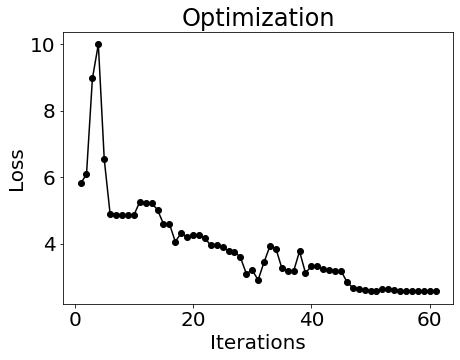

SVCLoss optimal value:  6.088246777083717
Optimal parameters: [ 2.77350229  8.83091932  6.38109711 -0.45831878 -0.43459466]


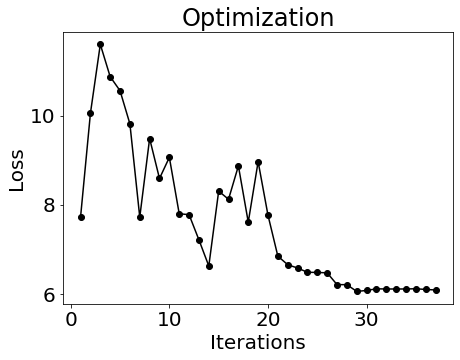

SVCLoss optimal value:  4.74583026912872
Optimal parameters: [ 4.02361665  6.22976365  3.14248236 -1.7245472   1.43743601]


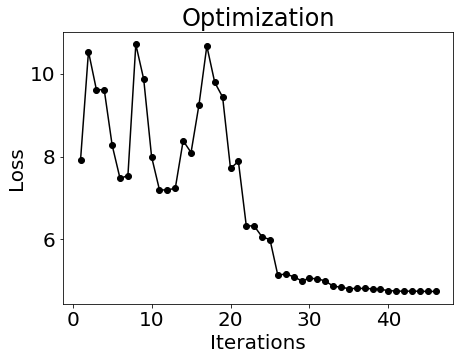

SVCLoss optimal value:  3.7730666348529045
Optimal parameters: [2.63598793 2.92261369 4.0825078  1.00890117 4.02892666]


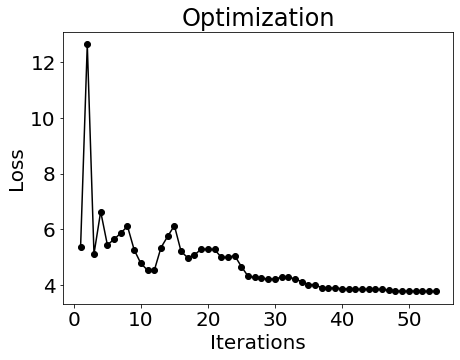

SVCLoss optimal value:  3.167175721031734
Optimal parameters: [2.74916121 3.56927172 4.38981008 5.10214708 5.25890963]


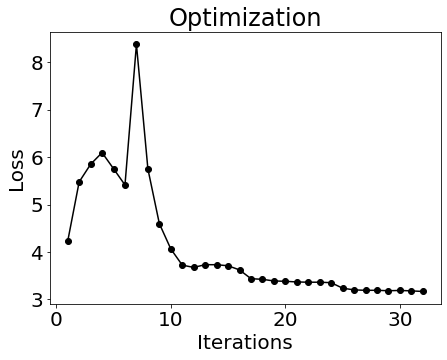

SVCLoss optimal value:  4.606287300419282
Optimal parameters: [2.52764038 3.18326978 4.3789952  5.69545573 5.05646446]


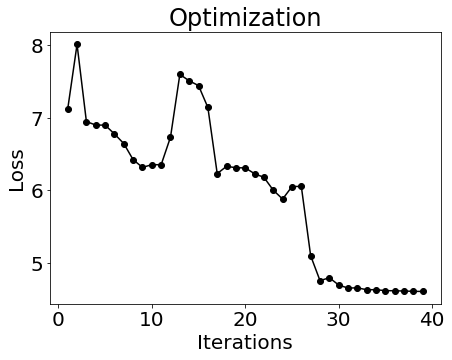



==== Cross-Validation Scores ====

Best train score:  1.0

Train set:
   Balanced accuracy:  0.96 +- 0.07
                  F1:  0.96 +- 0.07
             ROC_AUC:  0.96 +- 0.07
                 MCC:  0.92 +- 0.14

Test set:
   Balanced accuracy:  0.93 +- 0.06
                  F1:  0.93 +- 0.06
             ROC_AUC:  0.93 +- 0.06
                 MCC:  0.87 +- 0.11


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10

C = 1.0
class_weight = None
np.random.seed(seed)

for _seed in np.random.randint(2**16-1, size=2):

    n_splits = 5
    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )
    
    for train, test in cv.split(X, y):

        np.random.seed(_seed)
        init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
        init_params[0] = 2.0
        qkt = QKTKernel(
            fm,
            X[train], y[train],
            init_params,
            C=C, class_weight=class_weight,
            seed=_seed, plot=True,
        )
        qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=_seed, class_weight=class_weight)
        qsvc.fit(X[train], y[train])

        scores_tr.append(get_scores(qsvc, X[train], y[train]))
        scores_tt.append(get_scores(qsvc, X[test], y[test]))
        if scores_tt[-1][scoring] > best_score:
            best_score = scores_tt[-1][scoring]
            best_qsvc = qsvc

print('\n\n==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

In [11]:
scores_ = get_scores(best_qsvc, X, y)
print_scores(scores_, title='Best model / Entire set:')


Best model / Entire set:
   Balanced accuracy:  0.97
                  F1:  0.97
             ROC_AUC:  0.97
                 MCC:  0.95


## Best QSVM CV Predictions/Decision boundaries plot

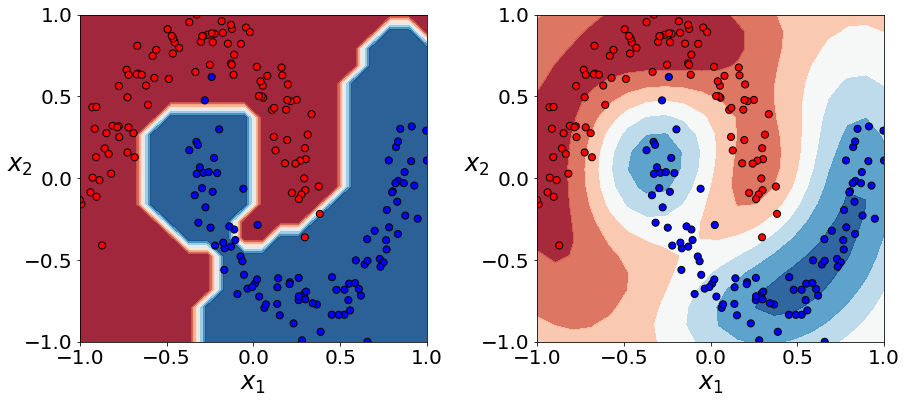

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()